In [1]:
%%writefile openmp_dijkstra.c
#include <stdio.h>
#include <stdlib.h>
#include <limits.h>
#include <omp.h>
#include <time.h>
#define INF INT_MAX
typedef struct { int **A; int n; } G;

G* make_graph(int n, double d, unsigned long long seed){
    srand(seed);
    G* g=(G*)malloc(sizeof(G)); g->n=n; g->A=(int**)malloc(n*sizeof(int*));
    for(int i=0;i<n;i++){ g->A[i]=(int*)malloc(n*sizeof(int));
        for(int j=0;j<n;j++){
            if(i==j) g->A[i][j]=0;
            else if ((double)rand()/RAND_MAX<d) g->A[i][j]=rand()%100+1;
            else g->A[i][j]=INF;
        }
    } return g;
}
void free_graph(G* g){ for(int i=0;i<g->n;i++) free(g->A[i]); free(g->A); free(g); }
void dseq(G* g,int s,int*dist){ int n=g->n; int*vis=(int*)calloc(n,sizeof(int));
    for(int i=0;i<n;i++) dist[i]=INF; dist[s]=0;
    for(int it=0; it<n-1; it++){
        int u=-1, md=INF;
        for(int v=0; v<n; v++) if(!vis[v] && dist[v]<md){ md=dist[v]; u=v; }
        if(u==-1) break; vis[u]=1;
        for(int v=0; v<n; v++){
            if(!vis[v] && g->A[u][v]!=INF && dist[u]!=INF){
                int nd=dist[u]+g->A[u][v]; if(nd<dist[v]) dist[v]=nd;
            }
        }
    } free(vis);
}
void dome(G* g,int s,int*dist,int th){ int n=g->n; int*vis=(int*)calloc(n,sizeof(int));
    for(int i=0;i<n;i++) dist[i]=INF; dist[s]=0; omp_set_num_threads(th);
    for(int it=0; it<n-1; it++){
        int u=-1, md=INF;
        #pragma omp parallel
        {
            int lu=-1, lm=INF;
            #pragma omp for nowait
            for(int v=0; v<n; v++) if(!vis[v] && dist[v]<lm){ lm=dist[v]; lu=v; }
            #pragma omp critical
            { if(lm<md){ md=lm; u=lu; } }
        }
        if(u==-1) break; vis[u]=1;
        #pragma omp parallel for schedule(static)
        for(int v=0; v<n; v++){
            if(!vis[v] && g->A[u][v]!=INF && dist[u]!=INF){
                int nd=dist[u]+g->A[u][v]; if(nd<dist[v]) dist[v]=nd;
            }
        }
    } free(vis);
}
int verify(int*a,int*b,int n){ for(int i=0;i<n;i++) if(a[i]!=b[i]) return 0; return 1; }
int main(){
    int sizes[]={500,1000,2000}; int ns=3; double dens=0.3; int ths[]={1,2,4,8}; int nt=4;
    printf("graph_size,density,threads,seq_time,par_time,speedup,efficiency,correct\n");
    for(int i=0;i<ns;i++){
        int n=sizes[i]; G* g=make_graph(n,dens,1234+n);
        int* ds=(int*)malloc(n*sizeof(int)); double t0=omp_get_wtime(); dseq(g,0,ds); double ts=omp_get_wtime()-t0;
        for(int j=0;j<nt;j++){
            int th=ths[j]; int* dp=(int*)malloc(n*sizeof(int));
            t0=omp_get_wtime(); dome(g,0,dp,th); double tp=omp_get_wtime()-t0;
            double sp=ts/tp; double eff=(sp/th)*100.0; int ok=verify(ds,dp,n);
            printf("%d,%.2f,%d,%.6f,%.6f,%.4f,%.2f,%d\n", n,dens,th,ts,tp,sp,eff,ok);
            free(dp);
        } free(ds); free_graph(g);
    } return 0;
}


Writing openmp_dijkstra.c


In [2]:
!gcc -O2 -fopenmp openmp_dijkstra.c -o openmp_dijkstra
!./openmp_dijkstra | tee results_openmp.csv


graph_size,density,threads,seq_time,par_time,speedup,efficiency,correct
500,0.30,1,0.002493,0.002633,0.9467,94.67,1
500,0.30,2,0.002493,0.002285,1.0909,54.54,1
500,0.30,4,0.002493,0.021906,0.1138,2.84,1
500,0.30,8,0.002493,0.054745,0.0455,0.57,1
1000,0.30,1,0.009844,0.010061,0.9784,97.84,1
1000,0.30,2,0.009844,0.008005,1.2297,61.49,1
1000,0.30,4,0.009844,0.048111,0.2046,5.12,1
1000,0.30,8,0.009844,0.120866,0.0814,1.02,1
2000,0.30,1,0.039079,0.038153,1.0243,102.43,1
2000,0.30,2,0.039079,0.028358,1.3781,68.90,1
2000,0.30,4,0.039079,0.114302,0.3419,8.55,1
2000,0.30,8,0.039079,0.302275,0.1293,1.62,1


,graph_size,density,threads,seq_time,par_time,speedup,efficiency,correct
0,500,0.3,1,0.002493,0.002633,0.9467,94.67,1
1,500,0.3,2,0.002493,0.002285,1.0909,54.54,1
2,500,0.3,4,0.002493,0.021906,0.1138,2.84,1
3,500,0.3,8,0.002493,0.054745,0.0455,0.57,1
4,1000,0.3,1,0.009844,0.010061,0.9784,97.84,1
5,1000,0.3,2,0.009844,0.008005,1.2297,61.49,1
6,1000,0.3,4,0.009844,0.048111,0.2046,5.12,1
7,1000,0.3,8,0.009844,0.120866,0.0814,1.02,1
8,2000,0.3,1,0.039079,0.038153,1.0243,102.43,1
9,2000,0.3,2,0.039079,0.028358,1.3781,68.90,1


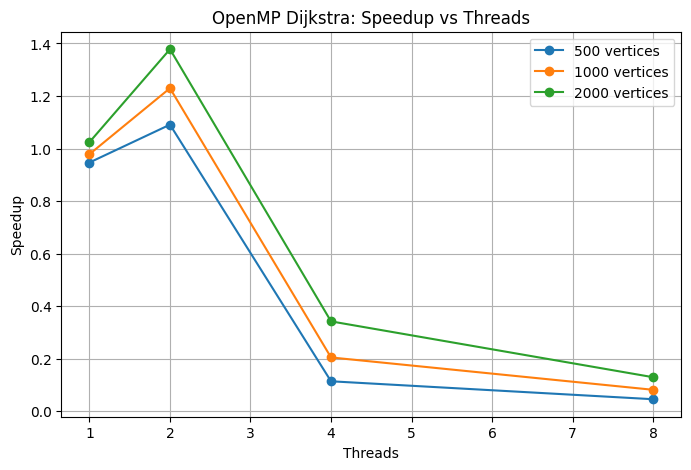

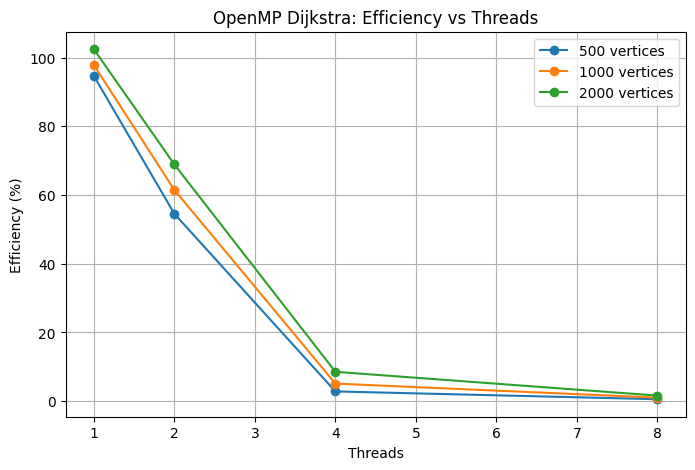

In [3]:
import pandas as pd, matplotlib.pyplot as plt
df=pd.read_csv('results_openmp.csv')
display(df)
plt.figure(figsize=(8,5))
for n in sorted(df.graph_size.unique()):
    sub=df[df.graph_size==n].sort_values('threads')
    plt.plot(sub.threads, sub.speedup, marker='o', label=f'{n} vertices')
plt.title('OpenMP Dijkstra: Speedup vs Threads'); plt.xlabel('Threads'); plt.ylabel('Speedup'); plt.grid(True); plt.legend(); plt.show()
plt.figure(figsize=(8,5))
for n in sorted(df.graph_size.unique()):
    sub=df[df.graph_size==n].sort_values('threads')
    plt.plot(sub.threads, sub.efficiency, marker='o', label=f'{n} vertices')
plt.title('OpenMP Dijkstra: Efficiency vs Threads'); plt.xlabel('Threads'); plt.ylabel('Efficiency (%)'); plt.grid(True); plt.legend(); plt.show()


In [4]:
%%writefile mpi_openmp_dijkstra.c
#include <stdio.h>
#include <stdlib.h>
#include <limits.h>
#include <omp.h>
#include <mpi.h>
#define INF INT_MAX
int** make_graph(int n,double d,unsigned int seed){
    srand(seed); int** A=(int**)malloc(n*sizeof(int*));
    for(int i=0;i<n;i++){ A[i]=(int*)malloc(n*sizeof(int));
        for(int j=0;j<n;j++){
            if(i==j) A[i][j]=0;
            else if((double)rand()/RAND_MAX<d) A[i][j]=rand()%100+1;
            else A[i][j]=INF;
        }
    } return A;
}
void free_graph(int**A,int n){ for(int i=0;i<n;i++) free(A[i]); free(A); }
int main(int argc,char**argv){
    MPI_Init(&argc,&argv); int rank,size; MPI_Comm_rank(MPI_COMM_WORLD,&rank); MPI_Comm_size(MPI_COMM_WORLD,&size);
    int n=1000; double dens=0.3;
    int** A=NULL;
    if(rank==0) A=make_graph(n,dens,1234);
    // Broadcast matrix row-by-row
    if(rank!=0){ A=(int**)malloc(n*sizeof(int*)); for(int i=0;i<n;i++) A[i]=(int*)malloc(n*sizeof(int)); }
    for(int i=0;i<n;i++) MPI_Bcast(A[i], n, MPI_INT, 0, MPI_COMM_WORLD);

    int* dist=(int*)malloc(n*sizeof(int)); int* vis=(int*)calloc(n,sizeof(int));
    for(int i=0;i<n;i++) dist[i]=INF; dist[0]=0;
    double t0=MPI_Wtime();
    for(int it=0; it<n-1; it++){
        int local_min=INF, local_u=-1;
        for(int v=rank; v<n; v+=size){ if(!vis[v] && dist[v]<local_min){ local_min=dist[v]; local_u=v; } }
        struct { int val; int idx; } in={local_min, local_u}, out;
        MPI_Allreduce(&in,&out,1,MPI_2INT,MPI_MINLOC,MPI_COMM_WORLD);
        int u=out.idx; if(u==-1) break; vis[u]=1;
        #pragma omp parallel for
        for(int v=0; v<n; v++){
            if(!vis[v] && A[u][v]!=INF && dist[u]!=INF){
                int nd=dist[u]+A[u][v]; if(nd<dist[v]) dist[v]=nd;
            }
        }
    }
    double t=MPI_Wtime()-t0;
    if(rank==0) printf("graph_size,%d,mpi_procs,%d,time,%.6f\n", n, size, t);
    free(dist); free(vis); free_graph(A,n);
    MPI_Finalize(); return 0;
}


Writing mpi_openmp_dijkstra.c


In [6]:
!apt-get install -y openmpi-bin openmpi-common libopenmpi-dev
!adduser --disabled-password --gecos "" mpiuser

!mpicc -fopenmp mpi_openmp_dijkstra.c -o mpi_openmp_dijkstra
!sudo -u mpiuser mpirun --oversubscribe -np 1 ./mpi_openmp_dijkstra | tee mpi_results.txt
!sudo -u mpiuser mpirun --oversubscribe -np 2 ./mpi_openmp_dijkstra | tee -a mpi_results.txt
!sudo -u mpiuser mpirun --oversubscribe -np 4 ./mpi_openmp_dijkstra | tee -a mpi_results.txt


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libopenmpi-dev is already the newest version (4.1.2-2ubuntu1).
openmpi-bin is already the newest version (4.1.2-2ubuntu1).
openmpi-common is already the newest version (4.1.2-2ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
Adding user `mpiuser' ...
Adding new group `mpiuser' (1000) ...
Adding new user `mpiuser' (1000) with group `mpiuser' ...
Creating home directory `/home/mpiuser' ...
Copying files from `/etc/skel' ...
graph_size,1000,mpi_procs,1,time,0.012978
graph_size,1000,mpi_procs,2,time,3.162817
graph_size,1000,mpi_procs,4,time,36.594471


,graph_size,mpi_procs,time
0,1000,1,0.012978
1,1000,2,3.162817
2,1000,4,36.594471


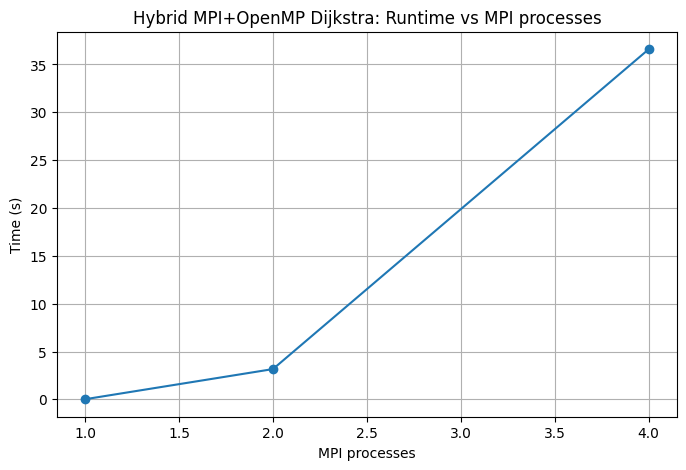

In [7]:
import re, pandas as pd, matplotlib.pyplot as plt
rows=[]
with open('mpi_results.txt') as f:
    for line in f:
        m=re.findall(r'graph_size,(\d+),mpi_procs,(\d+),time,([\d.]+)', line)
        if m: rows.append((int(m[0][0]), int(m[0][1]), float(m[0][2])))
df=pd.DataFrame(rows, columns=['graph_size','mpi_procs','time'])
display(df)
plt.figure(figsize=(8,5))
plt.plot(df.mpi_procs, df.time, marker='o')
plt.title('Hybrid MPI+OpenMP Dijkstra: Runtime vs MPI processes'); plt.xlabel('MPI processes'); plt.ylabel('Time (s)'); plt.grid(True); plt.show()
